# 実習8
#### RNNを用いて文章の感情分析

#### 参考
PythonとKerasによるディープラーニング
(https://www.amazon.co.jp/PythonとKerasによるディープラーニング-Francois-Chollet/dp/4839964262)
3章と6章


IMDbデータセットを使用。これはIMDb(Internet Movie Database)から収集された「肯定的」25000件と「否定的」25000件のレビューで構成されている。

### データの前処理

In [0]:
# まずはIMDbデータセットをダウンロードする

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000 #訓練データにおいて出現頻度が最も高い10000個の単語だけを残し、出現頻度が低い単語は捨てます。
maxlen = 500 #一つの文章につき最大500単語まで取り出す
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [0]:
# x_trainには単語IDが順番に入っている。y_trainにはレビューが肯定的か否定的かを表す0と1が入っている
print(x_train[0])
print(y_train[0:10])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
[1 0 0 1 0 0 1 0 1 0]


In [0]:
# 1文目のデータ(x_train[0])を文章に戻す。

# word_indexは単語を制すのインデックスにマッピングする辞書
word_index = imdb.get_word_index()

# 整数のインデックスを単語にマッピング
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# レビューをデコード：院でクスのオフセットとして3が指定されているのは、0, 1, 2はそれぞれ「パディング」「シーケンスの開始」
# 「不明」のインデックスとして予約されているためである。登録されていないキーに対しては?を返す。
# ' '.joinで各単語を半角スペースつなげて文章にする。 ' 'にカンマを入れると、単語の間にカンマが入る
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in x_train[0]])

print (decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [0]:
#word_indexとreverse_word_indexの中を見てみる
a = [(x,y) for (i, (x, y)) in enumerate(word_index.items()) if i<5]
b = [(x,y) for (i, (x, y)) in enumerate(reverse_word_index.items()) if i<5]
print(a)
print(b)
#ちゃんとvalueとkeyが逆になっている

[('fawn', 34701), ('tsukino', 52006), ('nunnery', 52007), ('sonja', 16816), ('vani', 63951)]
[(34701, 'fawn'), (52006, 'tsukino'), (52007, 'nunnery'), (16816, 'sonja'), (63951, 'vani')]


In [0]:
# 単語ID1から20の英単語を表示
tango = []
for i in range (1, 21):
    tango.append(reverse_word_index[i])
print(tango)

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on']


In [0]:
# 1つのデータ(文章)を500次元のベクトルに変換する。単語数が足りない文章は0で埋める。
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('input_train shape:', x_train.shape)
print('input_test shape:', x_test.shape)

Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [0]:
# validation dataの準備(validation dataは最初の5000data, 訓練データは残りの20000data)
x_val = x_train[:5000]
partial_x_train = x_train[5000:]

y_val = y_train[:5000]
partial_y_train = y_train[5000:]

#### まずはEmbeddingとDense層のみで分類してみる

In [0]:
epochs = 20
batch_size = 128

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Embedding, Dense
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32, input_length = 500)) #10000種類の単語に対して32次元の埋め込みを学習する、単語数(t)は500。

# 3次元テンソルを形状が(samples, max_len*32)の2次元テンソルに変換
model.add(Flatten())

model.add(Dense(1, activation = 'sigmoid')) #二値分類なのでノードが１つのDense層を追加
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
flatten_4 (Flatten)          (None, 16000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 16001     
Total params: 336,001
Trainable params: 336,001
Non-trainable params: 0
_________________________________________________________________


kerasのEmbeddingは正の整数（インデックス）を固定次元の密ベクトル(対応する単語ベクトル)に変換。埋め込み空間を誤差逆伝播により学習することができる。

model.add(Embedding(input_dim=1000, output_dim=64, input_length=10))において、

input_dim: 正の整数．語彙数．入力データの最大インデックス + 1．

output_dim: 0以上の整数．密なembeddingsの次元数．

input_length: 入力の系列長（定数）． この引数はこのレイヤーの後にFlattenからDenseレイヤーへ接続する際に必要 (これがないと，denseの出力のshapeを計算できない)．

自然言語処理での使い方としては、Embedding(語彙数, 分散ベクトルの次元数, 1文章の次元数))となる。


In [0]:
from keras import optimizers
model.compile(optimizer = optimizers.RMSprop(lr =0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

hist = model.fit(partial_x_train,
                 partial_y_train,
                 epochs = epochs,
                 batch_size = batch_size,
                 validation_data = (x_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 1s 42us/step - loss: 0.6036 - acc: 0.6849 - val_loss: 0.4335 - val_acc: 0.8360
Epoch 2/20
20000/20000 [==============================] - 1s 34us/step - loss: 0.3135 - acc: 0.8819 - val_loss: 0.2950 - val_acc: 0.8844
Epoch 3/20
20000/20000 [==============================] - 1s 32us/step - loss: 0.2168 - acc: 0.9196 - val_loss: 0.2751 - val_acc: 0.8908
Epoch 4/20
20000/20000 [==============================] - 1s 32us/step - loss: 0.1674 - acc: 0.9417 - val_loss: 0.2687 - val_acc: 0.8902
Epoch 5/20
20000/20000 [==============================] - 1s 33us/step - loss: 0.1321 - acc: 0.9574 - val_loss: 0.2652 - val_acc: 0.8914
Epoch 6/20
20000/20000 [==============================] - 1s 32us/step - loss: 0.1036 - acc: 0.9680 - val_loss: 0.2800 - val_acc: 0.8910
Epoch 7/20
20000/20000 [==============================] - 1s 30us/step - loss: 0.0796 - acc: 0.9786 - val_loss: 0.2888 - val_acc:

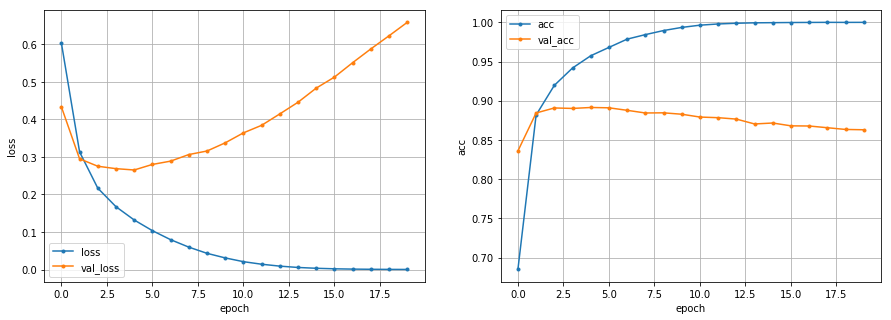

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['acc']
val_acc = hist.history['val_acc']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

#### RNNを使ってみる

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Embedding, Dense
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32, input_length = 500)) #10000種類の単語に対して32次元の埋め込みを学習する、単語数(t)は500。
model.add(SimpleRNN(32)) #SimpleRNNの入力次元は3次元で(batchsize, timesteps(ここでは単語ベクトルの数), 単語ベクトルの次元数)となる
model.add(Dense(1, activation = 'sigmoid')) #二値分類なのでノードが１つのDense層を追加
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras import optimizers
model.compile(optimizer = optimizers.RMSprop(lr =0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

epochs=10

hist = model.fit(partial_x_train,
                 partial_y_train,
                 epochs = epochs,
                 batch_size = 128,
                 validation_data = (x_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 17s 864us/step - loss: 0.0263 - acc: 0.9914 - val_loss: 0.6190 - val_acc: 0.8224
Epoch 2/10
20000/20000 [==============================] - 16s 815us/step - loss: 0.0196 - acc: 0.9936 - val_loss: 0.6685 - val_acc: 0.8332
Epoch 3/10
20000/20000 [==============================] - 17s 839us/step - loss: 0.0155 - acc: 0.9958 - val_loss: 0.7335 - val_acc: 0.7998
Epoch 4/10
20000/20000 [==============================] - 19s 961us/step - loss: 0.0125 - acc: 0.9961 - val_loss: 0.7723 - val_acc: 0.8054
Epoch 5/10
20000/20000 [==============================] - 18s 911us/step - loss: 0.0096 - acc: 0.9972 - val_loss: 0.8376 - val_acc: 0.7938
Epoch 6/10
20000/20000 [==============================] - 16s 801us/step - loss: 0.0063 - acc: 0.9981 - val_loss: 0.8292 - val_acc: 0.8104
Epoch 7/10
20000/20000 [==============================] - 16s 806us/step - loss: 0.0069 - acc: 0.9978 - val_loss: 0.9

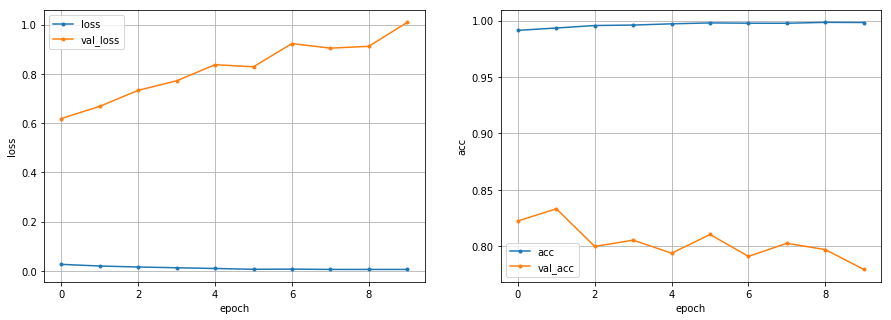

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['acc']
val_acc = hist.history['val_acc']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

### LSTMを使ってみる

In [0]:
# SimpleRNNをLSTMに変更するだけ
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(10000, 32, input_length = 500)) 
model.add(LSTM(32)) 
model.add(Dense(1, activation = 'sigmoid')) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer = optimizers.RMSprop(lr =0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

hist = model.fit(partial_x_train,
                 partial_y_train,
                 epochs = 10,
                 batch_size = 512,
                 validation_data = (x_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.6348 - acc: 0.6690 - val_loss: 0.5157 - val_acc: 0.8108
Epoch 2/10
20000/20000 [==============================] - 31s 2ms/step - loss: 0.4561 - acc: 0.8266 - val_loss: 0.4276 - val_acc: 0.8106
Epoch 3/10
20000/20000 [==============================] - 29s 1ms/step - loss: 0.3628 - acc: 0.8601 - val_loss: 0.3845 - val_acc: 0.8456
Epoch 4/10
20000/20000 [==============================] - 30s 2ms/step - loss: 0.2932 - acc: 0.8886 - val_loss: 0.3135 - val_acc: 0.8708
Epoch 5/10
20000/20000 [==============================] - 30s 1ms/step - loss: 0.2532 - acc: 0.9032 - val_loss: 0.3070 - val_acc: 0.8814
Epoch 6/10
20000/20000 [==============================] - 29s 1ms/step - loss: 0.2312 - acc: 0.9137 - val_loss: 0.3251 - val_acc: 0.8678
Epoch 7/10
20000/20000 [==============================] - 29s 1ms/step - loss: 0.2009 - acc: 0.9257 - val_loss: 0.3112 - val_acc:

In [0]:
import matplotlib.pyplot as plt
loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['acc']
val_acc = hist.history['val_acc']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

### 課題8-1
#### SimpleRNN層を連続で二層繋いでより表現力の高いモデルを構築
SimpleRNN(32, return_sequences = True)とすることで出力が3次元のテンソル(batchsize, timesteps, output_features)になる。次の層のSimepleRNNが情報を受け取ることができるようになる。return_sequencesの引数を指定しない場合、SimpleRNNの出力は2次元のテンソル(batchsize, output_features)となり、これが一番最後のRNNの出力。

### 課題8-2
#### GloVeの埋め込み行列を使って学習

単語の埋め込みについて、データベースが色々提供されている。それらをダウンロードすればkerasのEmbedding層で利用できる。Word2vecはそのうちの1つ。また、2014年にスタンフォード大学の研究者によって開発されたGlobal Vectors for Word Representation(GloVe)というアルゴリズムがよく知られている。この埋め込みアルゴリズムは、単語の共起関係からなる行列の因数分解に基づいている。GloVeの開発者はWikipediaやCommmon Crawlのデータから取得した数百万規模の英語のトークンをもとに学習済みの埋め込みを提供している。
GloVe単語埋め込みファイル(glove.6B.zip)は以下のURLよりダウンロードして解凍できる。このファイルには40万個の単語を対象とした100次元の埋め込みベクトルが含まれている。

https://nlp.stanford.edu/projects/glove

In [0]:
# 課題8-1
from keras.models import Sequential
from keras.layers import Flatten, Embedding, Dense
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(10000, 32, input_length = 500)) #10000種類の単語に対して32次元の埋め込みを学習する
model.add(SimpleRNN(32, return_sequences = True)) #このSimpleRNNの出力次元は3次元となる
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid')) #二値分類なのでノードが１つのDense層を追加
model.summary()

In [0]:
model.compile(optimizer = optimizers.RMSprop(lr =0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

hist = model.fit(partial_x_train,
                 partial_y_train,
                 epochs = 10,
                 batch_size = 512,
                 validation_data = (x_val, y_val))

In [0]:
# 課題8-2
import os

#  Gloveの埋め込みファイルが置かれているディレクトリを指定
glove_dir = 'glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

print('Found %ds word vectors.' % len(embeddings_index))

In [0]:
#GloVeの単語埋め込み行列の準備
max_features = 10000
embedding_dim = 100

embedding_matrix = np.zeros((max_features, embedding_dim))
for word in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            #埋め込みインデックスで見つからない単語は0で埋める
            embedding_matrix[i] = embedding_vector

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Embedding, Dense
from keras.layers import SimpleRNN

model = Sequential()
model.add(Embedding(10000, 100, input_length = 500)) #10000種類の単語に対して32次元の埋め込みを学習する
model.add(SimpleRNN(32, return_sequences = True)) #このSimpleRNNの出力次元は3次元となる
model.add(SimpleRNN(32))
model.add(Dense(1, activation = 'sigmoid')) #二値分類なのでノードが１つのDense層を追加
model.summary()

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
# VGG16の時と同様で、後ろの層が初期化された状態でEmbedding層の重みを学習可能にしてしまうと折角の表現が壊れてしまう。
# そのため、trainable属性をFalseにする。

In [0]:
epochs = 10
batch_size = 128

model.compile(optimizer = 'rmsprop',
              loss = 'binary_crossentropy',
              metrics = ['acc'])
hist = model.fit(x_train, y_train,
                 epochs = epochs,
                 batch_size = batch_size,
                 validation_data = (x_val, y_val))

In [0]:
import matplotlib.pyplot as plt
loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['acc']
val_acc = hist.history['val_acc']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()

#### (おまけ)　Embeddingを使わずDenseのみで分類してみる

In [0]:
# kerasで用意されているIMDbデータセットの読み込み
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

#引数num_words=10000は、訓練データにおいて出現頻度が最も高い10000個の単語だけを残し、出現頻度が低い単語は捨てることを意味する。

In [0]:
#データの中身を見てみる。
print('traindata[0]:',train_data[0]) # 単語IDが並ぶ
print('train_labels[0]:',train_labels[0]) # 0は否定的、1は肯定的を表す

traindata[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
train_labels[0]: 1


In [0]:
# 語彙数 (単語数を10000に設定しているため、10000を超えることはない(9999))
max([max(sequence) for sequence in train_data])

9999

In [0]:
# 1文目のデータ(x_train[0])を文章に戻す。

# word_indexは単語を制すのインデックスにマッピングする辞書
word_index = imdb.get_word_index()

# 整数のインデックスを単語にマッピング
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# レビューをデコード：院でクスのオフセットとして3が指定されているのは、0, 1, 2はそれぞれ「パディング」「シーケンスの開始」
# 「不明」のインデックスとして予約されているためである。登録されていないキーに対しては?を返す。
decoded_review = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])

print (decoded_review)

? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

In [0]:
# 単語IDのシーケンスをone-hotベクトルに変換
import numpy as np
def vectorize_sequences(sequences, dimension =10000):
    
    #形状が(len(sequences), dimension)の行列を作成し、0で埋める
    results = np.zeros((len(sequences), dimension))
    
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1. # results[i]のインデックスを1に設定
    return results

# 訓練データのベクトル化
x_train = vectorize_sequences(train_data)

# テストデータのベクトル化
x_test = vectorize_sequences(test_data)

In [0]:
# x_trainの中身を見てみる。25000個の訓練データ、1つの訓練データ(1つの文章)が1万次元の要素を持つ。
# 肯定的な単語や否定的な単語が何番目の次元か推定できれば、その文章が肯定的か否定的か判別がつきそう。
print(x_train, x_train.shape)
print(x_train[0][0:20])

[[0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]] (25000, 10000)
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
# ラベルのベクトル化
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
print(y_train, y_train.shape)

[1. 0. 0. ... 0. 1. 0.] (25000,)


In [0]:
# validation dataの準備
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [0]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(128, activation = 'relu', input_shape = (10000,)))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dense_8 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 1,282,209
Trainable params: 1,282,209
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras import optimizers
model.compile(optimizer = optimizers.RMSprop(lr =0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [0]:
# 学習
epochs = 20
batch_size = 512

hist = model.fit(partial_x_train,
                 partial_y_train,
                 epochs = epochs,
                 batch_size = batch_size,
                 validation_data = (x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 3s 215us/step - loss: 0.4849 - acc: 0.7649 - val_loss: 0.3385 - val_acc: 0.8646
Epoch 2/20
15000/15000 [==============================] - 2s 117us/step - loss: 0.2662 - acc: 0.8981 - val_loss: 0.2752 - val_acc: 0.8912
Epoch 3/20
15000/15000 [==============================] - 2s 115us/step - loss: 0.1814 - acc: 0.9319 - val_loss: 0.3853 - val_acc: 0.8454
Epoch 4/20
15000/15000 [==============================] - 2s 114us/step - loss: 0.1405 - acc: 0.9504 - val_loss: 0.3010 - val_acc: 0.8835
Epoch 5/20
15000/15000 [==============================] - 2s 115us/step - loss: 0.1027 - acc: 0.9651 - val_loss: 0.3327 - val_acc: 0.8819
Epoch 6/20
15000/15000 [==============================] - 2s 114us/step - loss: 0.0744 - acc: 0.9749 - val_loss: 0.3446 - val_acc: 0.8807
Epoch 7/20
15000/15000 [==============================] - 2s 114us/step - loss: 0.0622 - acc: 0.9824 - val_loss: 0.3743 - 

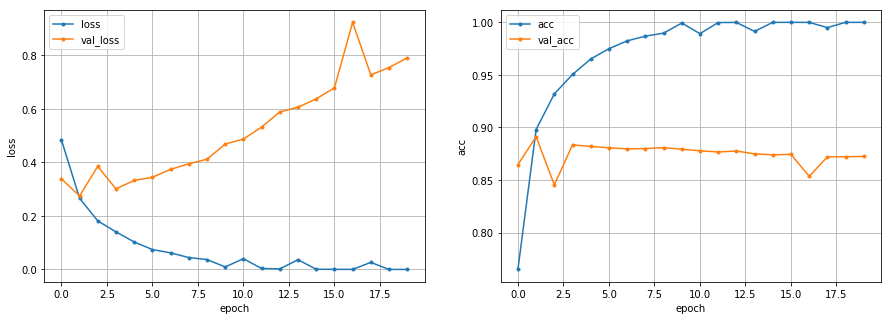

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = hist.history['loss']
val_loss = hist.history['val_loss']

acc = hist.history['acc']
val_acc = hist.history['val_acc']

# lossのグラフ
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

# accuracyのグラフ
plt.subplot(122)
plt.plot(range(epochs), acc, marker='.', label='acc')
plt.plot(range(epochs), val_acc, marker='.', label='val_acc')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.show()